In [1]:
import azureml.core
from azureml.core import Experiment, Workspace

In [2]:
ws = Workspace.from_config()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [3]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [4]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")

Data contains 353 training samples and 89 test samples


In [10]:
experiment = Experiment(workspace=ws, name="train-within-notebook")
run =  experiment.start_logging()

In [11]:
run.log('alpha', 0.03)

In [12]:
regression_model = Ridge(alpha=0.03)
regression_model.fit(data['train']['X'], data['train']['y'])
preds = regression_model.predict(data['test']['X'])

In [13]:
print('Mean Squared Error is', mean_squared_error(data['test']['y'], preds))
run.log('mse', mean_squared_error(data['test']['y'], preds))

Mean Squared Error is 3424.9003158960168


In [14]:
model_file_name = 'outputs/model.pkl'
joblib.dump(value = regression_model, filename = model_file_name)

['outputs/model.pkl']

In [15]:
run.upload_file(name = model_file_name, path_or_stream = model_file_name)

In [16]:
run.complete()

In [17]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
train-within-notebook,7099d9bd-cb6b-440b-88df-e4dfa3ed0ca4,,NotStarted,Link to Azure Portal,Link to Documentation


In [18]:

import numpy as np
from tqdm import tqdm

# list of numbers from 0 to 1.0 with a 0.05 interval
alphas = np.arange(0.0, 1.0, 0.05)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of runs, each train a model with a different alpha value
    with experiment.start_logging() as run:
        # Use Ridge algorithm to build a regression model
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X=data["train"]["X"], y=data["train"]["y"])
        preds = regression_model.predict(X=data["test"]["X"])
        mse = mean_squared_error(y_true=data["test"]["y"], y_pred=preds)

        # log alpha, mean_squared_error and feature names in run history
        run.log(name="alpha", value=alpha)
        run.log(name="mse", value=mse)

        # Save the model to the outputs directory for capture
        joblib.dump(value=regression_model, filename='outputs/model.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:57<00:00,  2.81s/it]


In [19]:
experiment

Name,Workspace,Report Page,Docs Page
train-within-notebook,prodmod,Link to Azure Portal,Link to Documentation


In [20]:
runs = {}
run_metrics = {}

# Create dictionaries containing the runs and the metrics for all runs containing the 'mse' metric
for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'mse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

# Find the run with the best (lowest) mean squared error and display the id and metrics
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['mse'])
best_run = runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', run_metrics[best_run_id])

# Tag the best run for identification later
best_run.tag("Best Run")

21it [00:04,  5.47it/s]


Best run is: 23f0b65e-cd3a-445d-a2ad-e83d9733e703
Metrics: {'alpha': 0.4, 'mse': 3295.741064355809}


### Deploy

In [21]:
# View the files in the run
for f in best_run.get_file_names():
    print(f)

outputs/model.pkl


In [22]:
model = best_run.register_model(model_name='best_model', model_path='outputs/model.pkl')

In [23]:
from azureml.core.model import Model

In [25]:
models = Model.list(ws, name='best_model')
for m in models:
    print(m.name, m.version)

best_model 1


#### Create scoring file

Create a scoring file offline

#### Describe your environment

In [26]:
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.image import ContainerImage

In [27]:
env = CondaDependencies()
env.add_conda_package("scikit-learn")
print(env.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
- scikit-learn



In [28]:
with open("myenv.yml","w") as f:
    f.write(env.serialize_to_string())

In [29]:
image_config = ContainerImage.image_configuration(execution_script="score.py", runtime="python", conda_file="myenv.yml")

### Describe your target compute

In [30]:
from azureml.core.webservice import AciWebservice

In [32]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, tags={'sample name': 'AML basics'}, description='This is simple model')

### Deploy the webservice

In [33]:
from azureml.core.webservice import Webservice

In [34]:
service = Webservice.deploy_from_model(name='my-aci-service',
                                      deployment_config=aciconfig,
                                      models=[model],
                                      image_config=image_config,
                                      workspace=ws)
service.wait_for_deployment(show_output=True)

Creating image

Image creation operation finished for image my-aci-service:1, operation "Succeeded"
Creating service
Running..............................
SucceededACI service creation operation finished, operation "Succeeded"


### Test the webservice

In [35]:
import json

In [37]:
service = ws.webservices['my-aci-service']

In [39]:
X_test[0:1, :].tolist()

[[0.0199132141783263,
  0.0506801187398187,
  0.104808689473925,
  0.0700725447072635,
  -0.0359677812752396,
  -0.0266789028311707,
  -0.0249926566315915,
  -0.00259226199818282,
  0.00371173823343597,
  0.0403433716478807]]

In [40]:
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

In [41]:
test_samples

'{"data": [[0.0199132141783263, 0.0506801187398187, 0.104808689473925, 0.0700725447072635, -0.0359677812752396, -0.0266789028311707, -0.0249926566315915, -0.00259226199818282, 0.00371173823343597, 0.0403433716478807]]}'

In [42]:
service.run(input_data = test_samples)

[217.67978776218712]

In [43]:

# score the entire test set.
test_samples = json.dumps({'data': X_test.tolist()})

result = service.run(input_data = test_samples)
residual = result - y_test

In [44]:
import requests

# use the first row from the test set again
test_samples = json.dumps({"data": X_test[0:1, :].tolist()})

# create the required header
headers = {'Content-Type':'application/json'}

# post the request to the service and display the result
resp = requests.post(service.scoring_uri, test_samples, headers = headers)
print(resp.text)

[217.67978776218712]


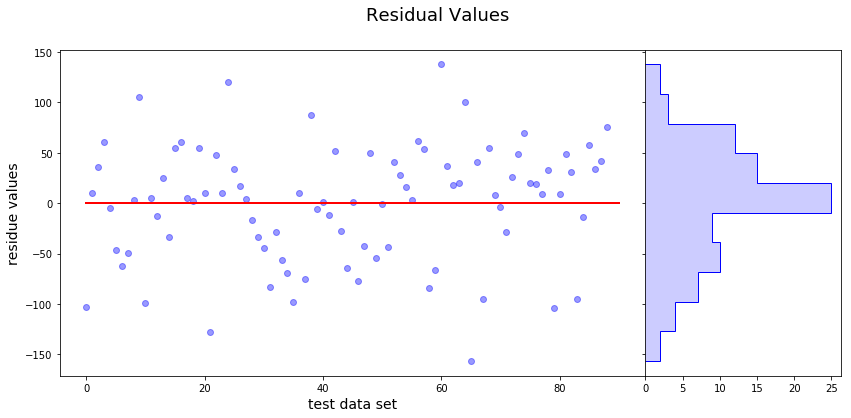

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[3, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Residual Values', fontsize = 18)

f.set_figheight(6)
f.set_figwidth(14)

a0.plot(residual, 'bo', alpha=0.4)
a0.plot([0,90], [0,0], 'r', lw=2)
a0.set_ylabel('residue values', fontsize=14)
a0.set_xlabel('test data set', fontsize=14)

a1.hist(residual, orientation='horizontal', color='blue', bins=10, histtype='step')
a1.hist(residual, orientation='horizontal', color='blue', alpha=0.2, bins=10)
a1.set_yticklabels([])

plt.show()

In [46]:
%%time
service.delete()

Wall time: 833 ms
